In [1]:
import numpy as np
import xarray as xr
# import dask.array as da
# from dask.distributed import Client, LocalCluster

import earthaccess
from functools import partial
import statsmodels.api as sm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

auth = earthaccess.login()

In [2]:
# L1B
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250501T183011.L1B.V3.nc"]
)
datatree1 = xr.open_datatree(granule[0])
ds1 = xr.merge(datatree1.to_dict().values())

# L2 data
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250501T183011.L2.OC_AOP.V3_0.nc"]
)
datatree2 = xr.open_datatree(granule[0])
ds2 = xr.merge(datatree2.to_dict().values())

# L2 BGC
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250501T183011.L2.OC_BGC.V3_0.nc"]
)
datatree2 = xr.open_datatree(granule[0])
ds2_BGC   = xr.merge(datatree2.to_dict().values())

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
ds2     = ds2.rename({'number_of_lines': 'scans', 'pixels_per_line': 'pixels'})
ds2_BGC = ds2_BGC.rename({'number_of_lines': 'scans', 'pixels_per_line': 'pixels'})

In [8]:
# merge 
l1b_vars_ = ["red_wavelength", "red_solar_irradiance", "watermask",
              "sensor_azimuth", "sensor_zenith", "solar_azimuth", "solar_zenith",
              "quality_flag", "rhot_red", ]
aop_vars_ = ["nflh", "l2_flags"]
ds = xr.merge([ds1[l1b_vars_], ds2[aop_vars_], ds2_BGC["chlor_a"]])

In [9]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:               (red_bands: 163, scans: 1710, pixels: 1272)
Coordinates:
    latitude              (scans, pixels) float32 9MB ...
    longitude             (scans, pixels) float32 9MB ...
Dimensions without coordinates: red_bands, scans, pixels
Data variables:
    red_wavelength        (red_bands) float32 652B ...
    red_solar_irradiance  (red_bands) float32 652B ...
    watermask             (scans, pixels) float32 9MB ...
    sensor_azimuth        (scans, pixels) float64 17MB ...
    sensor_zenith         (scans, pixels) float64 17MB ...
    solar_azimuth         (scans, pixels) float64 17MB ...
    solar_zenith          (scans, pixels) float64 17MB ...
    quality_flag          (scans, pixels) float32 9MB ...
    rhot_red              (red_bands, scans, pixels) float32 1GB ...
    nflh                  (scans, pixels) float32 9MB ...
    l2_flags              (scans, pixels) int32 9MB ...
    chlor_a               (scans, pixels) float32 9MB ...
Attributes: (12/36)
    title:                             PACE OCI Level-1B Data
    instrument:                        OCI
    platform:                          PACE
    processing_level:                  L1B
    cdm_data_type:                     swath
    geospatial_lat_units:              degrees_north
    ...                                ...
    time_coverage_start:               2025-05-01T18:30:11.093Z
    time_coverage_end:                 2025-05-01T18:35:10.976Z
    processing_version:                3.0.1
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L1B/SCI/3
    history:                           2025-08-07T02:31:59Z: l1bgen_oci ephfi...

In [10]:
cosSZA = np.cos(np.deg2rad(ds.solar_zenith))

In [11]:
# Get TOA radiance
R_TOA = ds.rhot_red * ds.red_solar_irradiance * cosSZA / np.pi

In [12]:
ds = ds.assign(radiance_red=R_TOA)

In [13]:
ds.to_netcdf("/home/zhe2/data/MyProjects/PACE_redSIF_PACE/sample_granule_20250501T183011_new_chl.nc")

In [17]:
ds2     = ds2.set_coords(("longitude", "latitude"))
ds2_BGC = ds2_BGC.set_coords(("longitude", "latitude"))

(-98.0, -75.0)

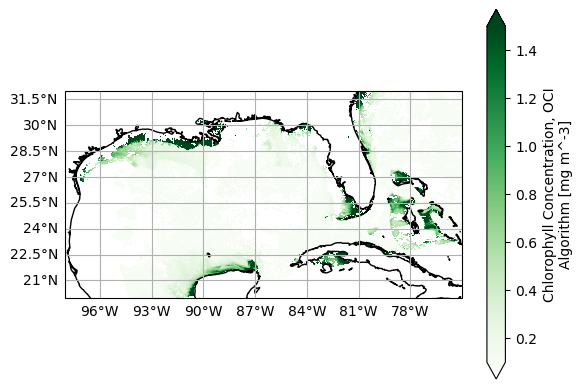

In [25]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = ds2_BGC["chlor_a"].plot(
    x="longitude", y="latitude", cmap="Greens", vmin=0.1, vmax=1.5, ax=ax
)
ax.set_ylim(20, 32)
ax.set_xlim(-98, -75)

(-98.0, -75.0)

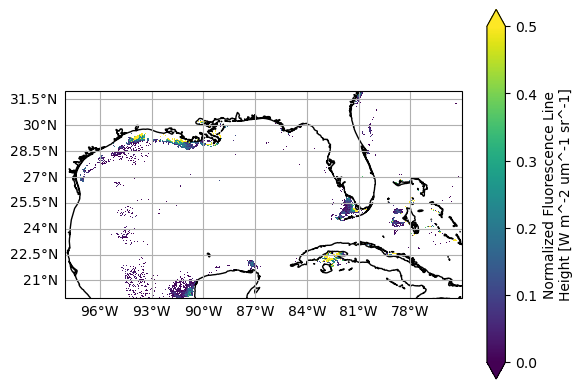

In [26]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = ds2["nflh"].plot(
    x="longitude", y="latitude", cmap="viridis", vmin=0, vmax=0.5, ax=ax
)
ax.set_ylim(20, 32)
ax.set_xlim(-98, -75)